In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import networkx as nx
import torch.optim as optim
import torch.nn.functional as F

In [105]:
N=25
g = nx.barabasi_albert_graph(N,1)
A = nx.to_numpy_array(g)

In [106]:
def LV(x,t,A,a,b):
    N = x.shape[0]
    dXdt = np.zeros(N)
    for n in range(0,N):
        dXdt[n] = x[n]*(a[n]-b[n]*x[n])
        for j in range(0,N):
            dXdt[n] -= A[n,j]*x[n]*x[j]
    return dXdt

def MM(x,t,A,a,b):
    N = x.shape[0]
    dXdt = np.zeros(N)
    for n in range(0,N):
        dXdt[n] = -x[n]
        for j in range(0,N):
            dXdt[n] -= A[n,j]*x[n]*x[j]
    return dXdt

In [107]:
x0 = np.random.uniform(0,1,N)
T = 5
dt = 0.05
nT = int(T/dt) 
t = np.linspace(0,T,nT)
a = np.random.uniform(0.5,1.5,N)
b = np.random.uniform(0.5,1.5,N)
x = sp.integrate.odeint(LV,x0,t,args=(A,a,b,))
ratio = 0.5
t_obs = T*ratio
nT_obs = int(T*ratio/dt)

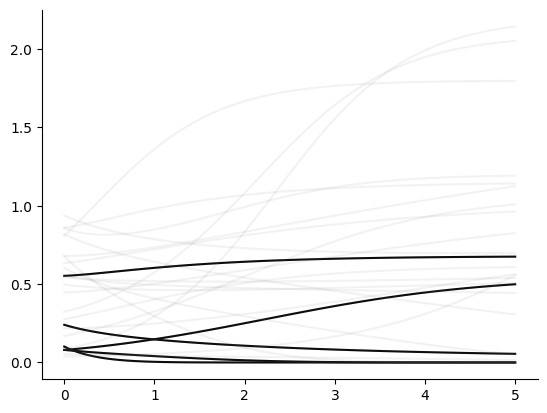

In [108]:
for n in range(0,5):
    plt.plot(t,x[:,n*1],'black')
for n in range(0,N):
    plt.plot(t,x[:,n],'grey',alpha=0.1)
#plt.axvline(t_obs,c='red',linestyle=':')
sns.despine()
data = torch.tensor(x[:nT_obs,:], dtype=torch.float32)

In [109]:
b_space = sp.linalg.null_space(x)
b_space.shape

(25, 0)

In [95]:
sns.heatmap(A+b_space[:,0])

IndexError: index 0 is out of bounds for axis 1 with size 0

In [63]:
y = sp.integrate.odeint(LV,x0,t,args=(A+5*b_space[:,2],a,b,))

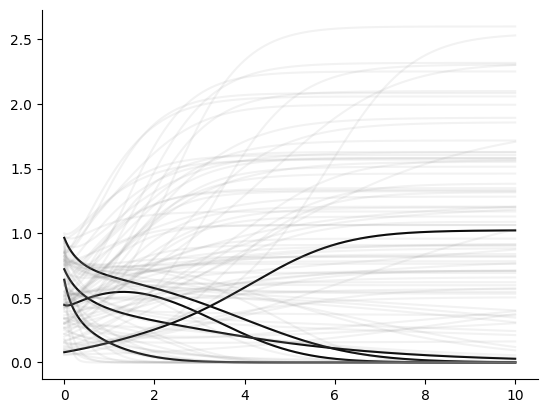

In [64]:
for n in range(0,5):
    plt.plot(t,y[:,n*10],'black')
for n in range(0,N):
    plt.plot(t,y[:,n],'grey',alpha=0.1)
#plt.axvline(t_obs,c='red',linestyle=':')
sns.despine()
data = torch.tensor(y[:nT_obs,:], dtype=torch.float32)

In [65]:
Ahat0 = np.linalg.pinv(x)@x@A[:,1]

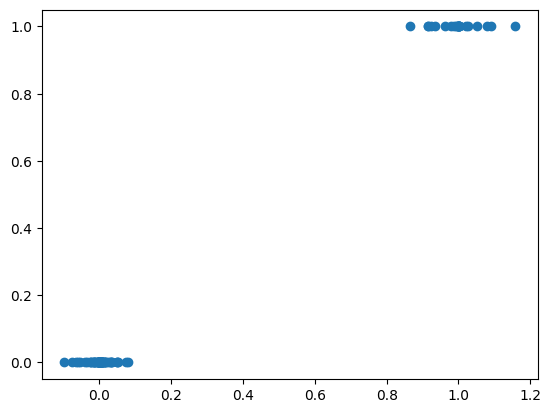

In [66]:
plt.scatter(Ahat0,A[:,1])

In [74]:
def derivative_approx(x,dt):
    dx = np.zeros(x.shape)
    for i in range(0,x.shape[1]):
        for t in range(0,x.shape[0]-1):
            dx[t,i] = (x[t+1,i]-x[t,i])*(1/dt)
    return(dx)

def cost_function_LV(A_i,i,x,dx,a,b):
    [T,N] = x.shape
    cost = 0
    for t in range(0,T):
        cost1 = (dx[t,i] - x[t,i]*(a[i]-b[i]*x[t,i]))
        for j in range(0,N):
            cost1-= A_i[j]*(-x[t,i]*x[t,j])
        cost += cost1**2
    return cost

def cost_gradient_LV(A_i,i,x,dx,a,b):
    [T,N] = x.shape
    grad = np.zeros(N)
    for t in range(0,T):
        cost1 = (dx[t,i] - x[t,i]*(a[i]-b[i]*x[t,i]))
        cost2 = 0
        for j in range(0,N):
            cost1-= A_i[j]*(-x[t,i]*x[t,j])
        for k in range(0,N):
            grad[k] += 2*cost1*(x[t,i]*x[t,k])
    return grad

In [75]:
def sgd(objective_function, gradient, A_i_init,i,x,dx,a,b, learning_rate=0.01, n_iterations=100):
    A_i = A_i_init
    history = [objective_function(A_i,i,x,dx,a,b)]
    for _ in range(n_iterations):
        grad = gradient(A_i,i,x,dx,a,b)
        A_i = A_i - learning_rate * grad
        history.append(objective_function(A_i,i,x,dx,a,b))
    return A_i

In [76]:
#A_i_init = np.random.rand(N)
dx = derivative_approx(x,dt)
A_i = sgd(cost_function_LV, cost_gradient_LV, A_i_init,0,x,dx,a,b, learning_rate=0.01, n_iterations=1000)

NameError: name 'A_i_init' is not defined

# Optimisation

In [5]:
import cvxpy as cp

In [15]:
def derivative_approx(x,dt):
    dx = np.zeros(x.shape)
    for i in range(0,x.shape[1]):
        for t in range(0,x.shape[0]-1):
            dx[t,i] = (x[t+1,i]-x[t,i])*(1/dt)
    return(dx)

def cost_function_LV(A_i,i,x,dx,a,b):
    [T,N] = x.shape
    cost = 0
    for t in range(0,T):
        cost1 = (dx[t,i] - x[t,i]*(a[i]-b[i]*x[t,i]))
        for j in range(0,N):
            cost1-= A_i[j]*(-x[t,i]*x[t,j])
        cost += cost1**2
    return cost

In [67]:
dx = derivative_approx(x,dt)

In [71]:
surrogate_matrix = np.zeros((N,N))
for i in range(0,N):
    print(i)
    A_i = cp.Variable(N)
    objective = cp.Minimize(cost_function_LV(A_i,i,x,dx,a,b))
    prob = cp.Problem(objective)
    prob.solve(verbose=False)
    surrogate_matrix[:,i] = np.array(A_i.value)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
